In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, make_scorer
)
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [148]:
# ===============================================================
# COACH CHANGE PREDICTION — DATA PREPARATION
# ===============================================================

# Load Data
coaches = pd.read_csv("data/coaches.csv")
teams = pd.read_csv("data/teams.csv")
awards_players = pd.read_csv("data/awards_players.csv")


# TARGET: "DID A CHANGE HAPPEN THIS SEASON?"
# If max_stint > 0, it means the starter (Stint 0) was replaced.
stint_counts = coaches.groupby(["tmID", "year"])["stint"].max().reset_index()
stint_counts = stint_counts.rename(columns={"stint": "max_stint_in_season"})

# Merge this info back to the coaches
coaches = coaches.merge(stint_counts, on=["tmID", "year"], how="left")

# Target = 1 if there was more than 1 coach (max_stint > 0)
coaches["mid_season_change"] = (coaches["max_stint_in_season"] > 0).astype(int)



# Compute win ratio
coaches["win_ratio"] = np.where(
    (coaches["post_wins"] == 0) & (coaches["post_losses"] == 0),
    coaches["won"] / (coaches["won"] + coaches["lost"]),
    (coaches["won"] + coaches["post_wins"]) /
    (coaches["won"] + coaches["lost"] + coaches["post_wins"] + coaches["post_losses"])
)

# Ensure correct order before applying cumulative stats
coaches = coaches.sort_values(["coachID", "year", "stint"]).reset_index(drop=True)

# Compute Cumulative Win Ratio
def compute_cumulative_win_ratio(group):
    group = group.copy()
    group["cumulative_win_ratio"] = 0.0
    for i in range(len(group)):
        if i == 0:
            group.loc[group.index[i], "cumulative_win_ratio"] = group.loc[group.index[i], "win_ratio"]
        else:
            prev = group.loc[group.index[i - 1], "cumulative_win_ratio"]
            curr = group.loc[group.index[i], "win_ratio"]
            # simple weighted smoothing (50/50)
            group.loc[group.index[i], "cumulative_win_ratio"] = 0.5 * curr + 0.5 * prev
    # shift so each season uses only past cumulative performance
    group["cumulative_win_ratio"] = group["cumulative_win_ratio"].shift(1)
    return group

# Apply per coach
coaches = coaches.groupby("coachID", group_keys=False).apply(compute_cumulative_win_ratio)

# Fill NaNs for rookie coaches (no prior data)
avg_cumulative_win_ratio = coaches["cumulative_win_ratio"].mean(skipna=True)
coaches["cumulative_win_ratio"] = coaches["cumulative_win_ratio"].fillna(avg_cumulative_win_ratio)


# Sort by team and year first
coaches = coaches.sort_values(["tmID", "year", "stint"]).reset_index(drop=True)
# Compute team win ratio
coaches["team_win_ratio"] = np.where(
    (coaches["post_wins"] == 0) & (coaches["post_losses"] == 0),
    coaches["won"] / (coaches["won"] + coaches["lost"]),
    (coaches["won"] + coaches["post_wins"]) /
    (coaches["won"] + coaches["lost"] + coaches["post_wins"] + coaches["post_losses"])
)

coaches["prev_team_win_ratio"] = coaches.groupby("tmID")["team_win_ratio"].shift(1)

# 3-year rolling average on past seasons
coaches["3yr_win_ratio"] = (
    coaches.groupby("tmID")["team_win_ratio"]
    .shift(1)  # use only past seasons
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

average_3yr_team_win_ratio = coaches["3yr_win_ratio"].mean(skipna=True)
coaches["3yr_win_ratio"] = coaches["3yr_win_ratio"].fillna(average_3yr_team_win_ratio)


# Expectation gap (current vs. recent average)
coaches["expectation_gap"] = coaches["cumulative_win_ratio"] - coaches["3yr_win_ratio"]



# Filter only Coach of the Year awards
coach_awards = awards_players[awards_players["award"] == "Coach of the Year"].copy()
coach_awards = coach_awards.rename(columns={"playerID": "coachID", "year": "award_year"})

# Merge award info into coaches (many-to-many, one row per award)
coaches_awards = coaches.merge(
    coach_awards[["coachID", "award_year"]],
    on="coachID",
    how="left"
)

# Only keep awards up to and including that season
coaches_awards["award_up_to_season"] = (
    coaches_awards["award_year"] < coaches_awards["year"]
).astype(int)

# Group by coach and season, sum awards
coach_award_count = (
    coaches_awards.groupby(["coachID", "year"])["award_up_to_season"]
    .sum()
    .reset_index()
    .rename(columns={"award_up_to_season": "coach_award_count"})
)

# Merge back into the original coaches dataframe
coaches = coaches.merge(coach_award_count, on=["coachID", "year"], how="left")

# Fill NaNs for coaches with no awards
coaches["coach_award_count"] = coaches["coach_award_count"].fillna(0).astype(int)


# merge teams info into coaches so each coach row has that season's team info
coaches = coaches.merge(
    teams[["year", "tmID", "playoff", "o_pts", "d_pts", "rank"]],
    on=["year", "tmID"],
    how="left",
    validate="m:1"   
)

coaches = coaches.sort_values(["tmID", "year", "stint"]).reset_index(drop=True)

coaches["team_prev_playoff"] = coaches.groupby("tmID")["playoff"].shift(1).map({"Y": 1, "N": 0})


teams_history = teams[["year", "tmID", "o_pts", "d_pts", "playoff"]].copy()
teams_history["year"] = teams_history["year"] + 1  # SHIFT FORWARD: Year 9 stats become Year 10 features

# Merge this "History" into the main dataframe
coaches = coaches.merge(
    teams_history, 
    on=["year", "tmID"], 
    how="left",
    suffixes=("", "_prev") # This avoids collision if columns exist
)

# NEW FEATURE: PYTHAGOREAN EXPECTATION (Underperformance)
# Did the coach lose more games than their points scored stats suggest?
# Formula: Pts^14 / (Pts^14 + OppPts^14)

coaches["prev_pythag_win_pct"] = (
    (coaches["o_pts_prev"].astype(float)**14) / 
    ((coaches["o_pts_prev"].astype(float)**14) + (coaches["d_pts_prev"].astype(float)**14))
)

coaches["prev_underperformance"] = coaches["prev_pythag_win_pct"] - coaches["prev_team_win_ratio"]

coaches["prev_underperformance"] = coaches["prev_underperformance"].fillna(0)
    

# 8. Playoff Streak
coaches["prev_playoff_numeric"] = coaches["playoff_prev"].map({"Y": 1, "N": 0}).fillna(0)

# ... rest of streak logic ...
# Playoff miss streak
def playoff_streak(series):
    streaks = []
    streak = 0
    for made in series:
        if made == 0:
            streak += 1
        else:
            streak = 0
        streaks.append(streak)
    return streaks

coaches["playoff_miss_streak"] = coaches.groupby("tmID")["team_prev_playoff"].transform(playoff_streak)



# NEW FEATURE: TENURE (Years with current team)
coaches = coaches.sort_values(["tmID", "year", "stint"])

# Calculate how many seasons this coach has been with this team (entering this season)
coaches["tenure"] = coaches.groupby(["tmID", "coachID"]).cumcount() + 1


coaches["win_ratio_lag1"] = coaches.groupby("tmID")["team_win_ratio"].shift(1)
coaches["win_ratio_lag2"] = coaches.groupby("tmID")["team_win_ratio"].shift(2)

# Momentum: Recent Trend vs Previous Trend
# If Lag1 (Last Year) is much lower than Lag2 (Year Before), Momentum is Negative.
coaches["momentum"] = coaches["win_ratio_lag1"] - coaches["win_ratio_lag2"]
coaches["momentum"] = coaches["momentum"].fillna(0)


features_to_keep = [
    "tmID", "year", "coachID", "stint", "mid_season_change",
    "cumulative_win_ratio", "3yr_win_ratio", "expectation_gap",
    "coach_award_count", "prev_underperformance", "playoff_miss_streak",
    "tenure", "momentum"
]
# Keep only what we need
final_df = coaches[features_to_keep].copy()

# Inspect Year 
final_df[final_df["year"] == 10].head(20)

/tmp/ipykernel_4623/656004896.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  coaches = coaches.groupby("coachID", group_keys=False).apply(compute_cumulative_win_ratio)


,tmID,year,coachID,stint,mid_season_change,cumulative_win_ratio,3yr_win_ratio,expectation_gap,coach_award_count,prev_underperformance,playoff_miss_streak,tenure,momentum
1,ATL,10,meadoma99w,0,0,0.117647,0.117647,0.000000,0,0.025792,1,2,0.000000
13,CHI,10,keyst99wc,0,0,0.352941,0.303922,0.049020,0,0.093868,3,2,-0.058824
24,CON,10,thibami99w,0,0,0.598316,0.617233,-0.018917,2,0.094902,0,7,0.081081
35,DET,10,laimbbi01w,1,1,0.650009,0.674301,-0.024293,1,0.017446,0,8,0.007752
36,DET,10,mahorri01w,2,1,0.519859,0.558140,-0.038281,0,0.358531,0,1,-0.341085
55,IND,10,dunnli99wc,0,0,0.430743,0.556607,-0.125863,0,0.036216,0,2,-0.113514
68,LAS,10,coopemi01w,0,0,0.542817,0.520475,0.022342,1,0.026113,0,8,0.280882
83,MIN,10,gilloje01w,0,0,0.519859,0.285205,0.234654,0,0.087819,5,1,0.176471
94,NYL,10,coylepa99w,1,1,0.496882,0.444330,0.052553,0,-0.002210,0,6,0.090541
95,NYL,10,donovan99w,2,1,0.505436,0.454134,0.051303,0,0.194849,1,1,-0.197059


Model Random Forest
Year Target: 8
Treino: (102, 13) | Teste (8): (13, 13)

Evaluation for year 8:
Accuracy:  0.846
Precision: 0.000
Recall:    0.000
F1-score:  0.000
Spearman:  -0.309

Teams predicted to change coaches:
   tmID     coachID  pred_proba  prev_underperformance
92  NYL  coylepa99w    0.810511              -0.153191

🏀 Top predicted coach changes (with actual result):
     pred_proba  predicted_change  mid_season_change
92     0.810511                 1                  0
44     0.256424                 0                  0
11     0.193499                 0                  0
122    0.175534                 0                  0
66     0.098691                 0                  0
142    0.095367                 0                  0
81     0.080706                 0                  0
33     0.048316                 0                  0
107    0.027150                 0                  0
132    0.026054                 0                  0
157    0.024754                 0

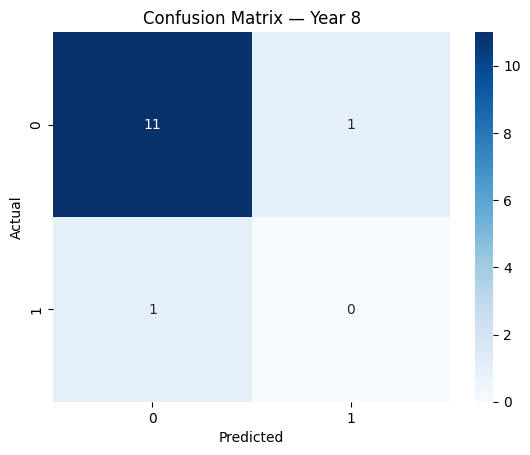

/tmp/ipykernel_4623/2570604793.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")


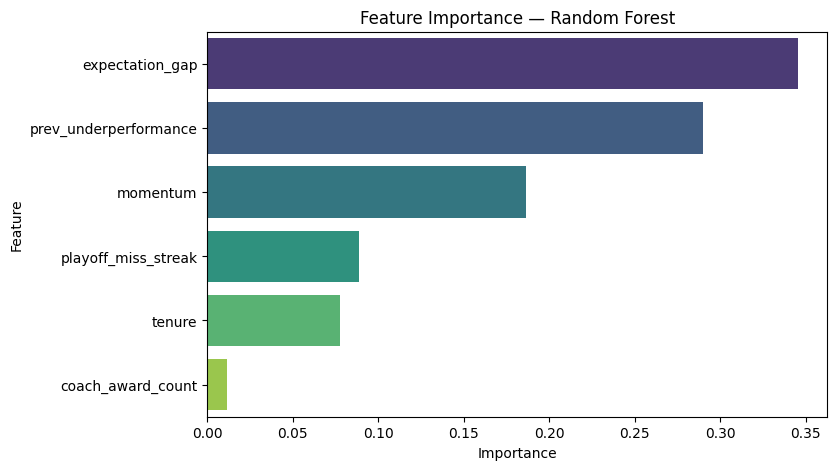


Feature Influence (higher = more impact on firing prediction):
                 Feature  Importance
0        expectation_gap    0.345345
3  prev_underperformance    0.289737
5               momentum    0.186580
2    playoff_miss_streak    0.088919
4                 tenure    0.077959
1      coach_award_count    0.011459


In [ ]:
# ===============================================================
# COACH CHANGE PREDICTION — MODEL & EVALUATION - RANDOM FOREST
# ===============================================================


# Define features and target

features = [
    "cumulative_win_ratio",
    "expectation_gap",
    "coach_award_count",
    "playoff_miss_streak",
    "prev_underperformance",
    "tenure",
    "momentum"
]
target = "mid_season_change"

min_stints = final_df.groupby(["tmID", "year"])["stint"].transform("min")
valid_data = final_df[final_df["stint"] == min_stints].dropna(subset=[target]).copy()

target_year = 10
train_data = valid_data[valid_data["year"] < target_year]
test_data  = valid_data[valid_data["year"] == target_year]

print(f"Model Random Forest")
print(f"Year Target: {target_year}")
print(f"Treino: {train_data.shape} | Teste ({target_year}): {test_data.shape}")


X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)

# Predictions

test_data = test_data.copy()
test_data.loc[:, "pred_proba"] = model.predict_proba(X_test)[:, 1]

threshold = 0.4
test_data.loc[:, "predicted_change"] = (test_data["pred_proba"] > threshold).astype(int)


acc = accuracy_score(y_test, test_data["predicted_change"])
prec = precision_score(y_test, test_data["predicted_change"])
rec = recall_score(y_test, test_data["predicted_change"])
f1 = f1_score(y_test, test_data["predicted_change"])
spearman_corr, spearman_p = spearmanr(y_test, test_data["pred_proba"])

print(f"\nEvaluation for year {target_year}:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"Spearman:  {spearman_corr:.3f}")

predicted_teams = test_data[test_data["predicted_change"] == 1].sort_values("pred_proba", ascending=False)

print("\nTeams predicted to change coaches:")
# We show tmID because that is the "Entity" the question asks for
print(predicted_teams[["tmID", "coachID", "pred_proba", "prev_underperformance"]])

print("\n🏀 Top predicted coach changes (with actual result):")
print(
    test_data[[
        "pred_proba", "predicted_change", 
        "mid_season_change"#, "cumulative_win_ratio"
    ]]
    .sort_values("pred_proba", ascending=False)
    .head(test_data.shape[0])
)

# Evaluation


# Confusion Matrix

# Column [0]: probability of class 0: coach stays

# Column [1]: probability of class 1: coach changes/fired


cm = confusion_matrix(y_test, test_data["predicted_change"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — Year {target_year}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance

importance = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance — Random Forest")
plt.show()

print("\nFeature Influence (higher = more impact on firing prediction):")
print(importance)


Model Logistic Regression
Year Target: 10
Treino: (129, 13) | Teste (10): (13, 13)
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Evaluation for year 10:
Accuracy:  0.846
Precision: 0.600
Recall:    1.000
F1-score:  0.750
Spearman:  0.586

Teams predicted to change coaches:
    tmID     coachID  pred_proba  prev_underperformance
124  SAC  bouceje01w    0.479383              -0.049029
109  PHO  gaineco01w    0.408035               0.030575
94   NYL  coylepa99w    0.374056              -0.002210
55   IND  dunnli99wc    0.360320               0.036216
35   DET  laimbbi01w    0.356826               0.017446

🏀 Top predicted coach changes (with actual result):
     pred_proba  predicted_change  mid_season_change  cumulative_win_ratio
124    0.479383                 1                  1              0.527027
109    0.408035                 1                  0              0.470588
94     0.374056                 1                  1              0.496882
55     0.360320     

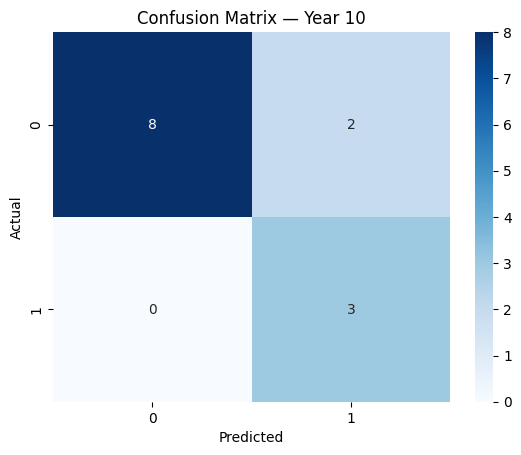


Feature Influence (higher = more impact on firing prediction):
                 Feature  Coefficient
0   cumulative_win_ratio     0.129491
5                 tenure     0.120146
3    playoff_miss_streak     0.076047
6               momentum    -0.168526
1        expectation_gap    -0.213559
2      coach_award_count    -0.215104
4  prev_underperformance    -0.496310


In [174]:
# ===============================================================
# COACH CHANGE PREDICTION — MODEL & EVALUATION - LOGISTIC REGRESSION
# ===============================================================


# Define features and target

features = [
    "cumulative_win_ratio",
    "expectation_gap",
    "coach_award_count",
    "playoff_miss_streak",
    "prev_underperformance",
    "tenure",
    "momentum"
]
target = "mid_season_change"

min_stints = final_df.groupby(["tmID", "year"])["stint"].transform("min")
valid_data = final_df[final_df["stint"] == min_stints].dropna(subset=[target]).copy()

target_year = 10
train_data = valid_data[valid_data["year"] < target_year]
test_data  = valid_data[valid_data["year"] == target_year]

print(f"Model Logistic Regression")
print(f"Year Target: {target_year}")

print(f"Treino: {train_data.shape} | Teste ({target_year}): {test_data.shape}")


X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', random_state=42))
])

param_grid = {
    'logreg__class_weight': ['balanced', {0: 1, 1: 3}, {0: 1, 1: 4}], # 1:10 is "Super Paranoid"
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2']
}

model = GridSearchCV(
pipeline, 
    param_grid, 
    cv=5,             
    scoring='average_precision',  
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train)

# Predictions

test_data = test_data.copy()
test_data.loc[:, "pred_proba"] = model.predict_proba(X_test)[:, 1]

threshold = 0.35
test_data.loc[:, "predicted_change"] = (test_data["pred_proba"] > threshold).astype(int)


acc = accuracy_score(y_test, test_data["predicted_change"])
prec = precision_score(y_test, test_data["predicted_change"])
rec = recall_score(y_test, test_data["predicted_change"])
f1 = f1_score(y_test, test_data["predicted_change"])
spearman_corr, spearman_p = spearmanr(y_test, test_data["pred_proba"])

print(f"\nEvaluation for year {target_year}:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"Spearman:  {spearman_corr:.3f}")

predicted_teams = test_data[test_data["predicted_change"] == 1].sort_values("pred_proba", ascending=False)

print("\nTeams predicted to change coaches:")
# We show tmID because that is the "Entity" the question asks for
print(predicted_teams[["tmID", "coachID", "pred_proba", "prev_underperformance"]])

print("\n🏀 Top predicted coach changes (with actual result):")
print(
    test_data[[
        "pred_proba",
        "predicted_change", "mid_season_change", "cumulative_win_ratio"
    ]]
    .sort_values("pred_proba", ascending=False)
    .head(test_data.shape[0])
)

# Evaluation


# Confusion Matrix

# Column [0]: probability of class 0: coach stays

# Column [1]: probability of class 1: coach changes/fired


cm = confusion_matrix(y_test, test_data["predicted_change"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — Year {target_year}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance

importance = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.best_estimator_.named_steps['logreg'].coef_[0]
}).sort_values("Coefficient", ascending=False)

print("\nFeature Influence (higher = more impact on firing prediction):")
print(importance)


In [188]:
# ===============================================================
# COACH CHANGE PREDICTION — ENSEMBLE MODEL (RF + LR)
# ===============================================================


# 1. SETUP & DATA SPLIT

features = [
    "cumulative_win_ratio",
    "expectation_gap",
    "coach_award_count",
    "playoff_miss_streak",
    "prev_underperformance",
    "tenure",
    "momentum"
]
target = "mid_season_change"

# Filter for Starters (Min Stint)
min_stints = final_df.groupby(["tmID", "year"])["stint"].transform("min")
valid_data = final_df[final_df["stint"] == min_stints].dropna(subset=[target]).copy()

target_year = 10
train_data = valid_data[valid_data["year"] < target_year]
test_data  = valid_data[valid_data["year"] == target_year]

print(f"Training Ensemble on {len(train_data)} rows.")
print(f"Predicting for {len(test_data)} teams in Year {target_year}.")

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# 2. MODEL 1: RANDOM FOREST (The "Stability" Expert)

print("\nTraining Model 1: Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train, y_train)
probs_rf = rf_model.predict_proba(X_test)[:, 1]

# 3. MODEL 2: LOGISTIC REGRESSION (The "Ranking" Expert)

print("Training Model 2: Logistic Regression (Tuned)...")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='liblinear', random_state=42))
])

param_grid = {
    'logreg__class_weight': [{0: 1, 1: 5}, {0: 1, 1: 8}, {0: 1, 1: 10}],
    'logreg__C': [1, 10, 100],
    'logreg__penalty': ['l1', 'l2']
}

lr_model = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,             
    scoring='f1',  
    n_jobs=-1,
    verbose=0
)
lr_model.fit(X_train, y_train)
probs_lr = lr_model.predict_proba(X_test)[:, 1]

print(f"Best LR Params: {lr_model.best_params_}")

# 4. THE ENSEMBLE (Averaging)
# ===============================================================
# We take the average of both models.
# This smooths out the "Paranoid" LR and boosts the "Shy" RF.
final_probs = (probs_rf + probs_lr) / 2

test_data = test_data.copy()
test_data["prob_rf"] = probs_rf
test_data["prob_lr"] = probs_lr
test_data["prob_ensemble"] = final_probs

# Threshold 0.35 is usually a good sweet spot for ensembles
threshold = 0.35
test_data["predicted_change"] = (test_data["prob_ensemble"] > threshold).astype(int)

# 5. EVALUATION
# ===============================================================
print("\n" + "="*40)
print("ENSEMBLE RESULTS")
print("="*40)

# Metrics
acc = accuracy_score(y_test, test_data["predicted_change"])
prec = precision_score(y_test, test_data["predicted_change"], zero_division=0)
rec = recall_score(y_test, test_data["predicted_change"])
f1 = f1_score(y_test, test_data["predicted_change"])
spearman_corr, _ = spearmanr(y_test, test_data["prob_ensemble"])

print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"Spearman:  {spearman_corr:.3f}")

# 6. THE FINAL LIST
print("\nProbability to change (Ensemble > {:.2f}):".format(threshold))
hit_list = test_data[test_data["predicted_change"] == 1].sort_values("prob_ensemble", ascending=False)

# Showing breakdown so you can see which model blamed them
cols = ["tmID", "coachID", "prob_ensemble", "prob_rf", "prob_lr", "mid_season_change"]
print(hit_list[cols])

# Answer Set
team_set = set(hit_list["tmID"].unique())
print(f"\nTeams predicted to change: {team_set}")

Training Ensemble on 129 rows.
Predicting for 13 teams in Year 10.

Training Model 1: Random Forest...
Training Model 2: Logistic Regression (Tuned)...
Best LR Params: {'logreg__C': 1, 'logreg__class_weight': {0: 1, 1: 10}, 'logreg__penalty': 'l1'}

ENSEMBLE RESULTS
Accuracy:  0.769
Precision: 0.500
Recall:    1.000
F1-score:  0.667
Spearman:  0.488

Probability to change (Ensemble > 0.35):
    tmID     coachID  prob_ensemble   prob_rf   prob_lr  mid_season_change
124  SAC  bouceje01w       0.592427  0.429347  0.755507                  1
109  PHO  gaineco01w       0.437183  0.234404  0.639963                  0
55   IND  dunnli99wc       0.401253  0.220378  0.582128                  0
94   NYL  coylepa99w       0.362847  0.051461  0.674233                  1
144  SEA  aglerbr99w       0.358000  0.168081  0.547919                  0
35   DET  laimbbi01w       0.355301  0.130731  0.579871                  1

Teams predicted to change: {'PHO', 'DET', 'SEA', 'SAC', 'IND', 'NYL'}
